### Урок3. Связь бизнес-показателей и DS-метрик
### Домашнее задание


#### Определение Сердечно-сосудистых заболеваний
ссылка на соревнование - https://mlbootcamp.ru/ru/round/12/sandbox/

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

##### Объективные признаки:
- Возраст
- Рост
- Вес
- Пол
##### Результаты измерения:
- Артериальное давление верхнее и нижнее
- Холестерин
- Глюкоза
##### Субъективные признаки:
- Курение
- Употребление Алкоголя
- Физическая активность

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.
Все показатели даны на момент осмотра.
Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)



1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег , бустинг ансамбль, лес и т.д - на ваш выбор 2-3 варианта 
посмотреть на дс метрики
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики), 
точность полнота точность полнота аук
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.utils import compute_class_weight

In [16]:
# Load the dataset
df = pd.read_csv('train_case2.csv', delimiter=';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [17]:
# Split the dataset into features (X) and target variable (y)
X = df.drop('cardio', axis=1)
y = df['cardio']

In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [19]:
# Scale the features
scaler = RobustScaler() # MaxAbsScaler, MinMaxScaler, StandardScaler, RobustScaler - устойчив к выбросам

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y)

In [21]:
# Define the models
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, solver='liblinear', class_weight={0: class_weights[0], 1: class_weights[1]})),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('Random Forest', RandomForestClassifier())
]

In [22]:
# Define the metrics
metrics = ['Precision', 'Recall', 'F1-Score', 'ROC AUC']

# Store the results
results = []

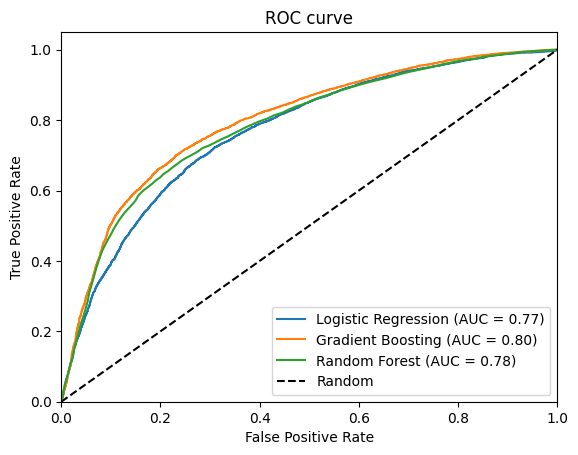

In [23]:
# Perform cross-validation and evaluate each model
for model_name, model in models:
    if model_name == 'Gradient Boosting' or model_name == 'Random Forest':
        model.fit(X_train_scaled, y_train, sample_weight=[class_weights[int(label)] for label in y_train])
    else:
        model.fit(X_train_scaled, y_train)
    
    y_scores = cross_val_predict(model, X_test_scaled, y_test, cv=16, method='predict_proba')[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = roc_auc_score(y_test, y_scores)
    plt.plot(fpr, tpr, label='{} (AUC = {:.2f})'.format(model_name, roc_auc))

    y_pred = cross_val_predict(model, X_test_scaled, y_test, cv=16)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append([model_name, precision, recall, f1, roc_auc])
    
# Create a DataFrame from the results
df_results = pd.DataFrame(results, columns=['Model', 'Precision', 'Recall', 'F1-Score', 'ROC AUC'])

    
# Plot the ROC curves
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()


In [24]:
df_results

,Model,Precision,Recall,F1-Score,ROC AUC
0,Logistic Regression,0.720963,0.660944,0.689650,0.768265
1,Gradient Boosting,0.750945,0.688212,0.718211,0.797636
2,Random Forest,0.728182,0.693406,0.710369,0.783312


#### Без балансировки классов:

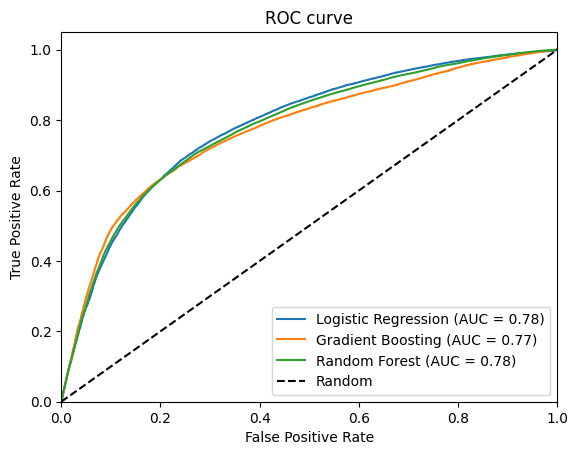

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler

# Load the dataset
df = pd.read_csv('train_case2.csv', delimiter=';')

# Split the dataset into features (X) and target variable (y)
X = df.drop('cardio', axis=1)
y = df['cardio']

# Scale the features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# Define the models
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, solver='sag')),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('Random Forest', RandomForestClassifier())
]

# Define the metrics
metrics = ['Precision', 'Recall', 'F1-Score', 'ROC AUC']

# Store the results
results = []

# Perform cross-validation and evaluate each model
for model_name, model in models:
    y_scores = cross_val_predict(model, X_scaled, y, cv=16, method='predict_proba')[:, 1]
    fpr, tpr, thresholds = roc_curve(y, y_scores)
    roc_auc = roc_auc_score(y, y_scores)

    y_pred = cross_val_predict(model, X_scaled, y, cv=16)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    results.append([model_name, precision, recall, f1, roc_auc])
    plt.plot(fpr, tpr, label='{} (AUC = {:.2f})'.format(model_name, roc_auc))
    
# Create a DataFrame from the results
df_results = pd.DataFrame(results, columns=['Model', 'Precision', 'Recall', 'F1-Score', 'ROC AUC'])


# Plot the ROC curves
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()


In [26]:
df_results

,Model,Precision,Recall,F1-Score,ROC AUC
0,Logistic Regression,0.741917,0.678350,0.708711,0.784580
1,Gradient Boosting,0.738741,0.667801,0.701482,0.771706
2,Random Forest,0.734642,0.677264,0.704787,0.779318


### Выводы
- В случае сильного дисбаланса классов лучше показывает себя модель Logistic Regression.
- Но если применить балансировку данных, то Gradient Boosting покажет наилучший результат.

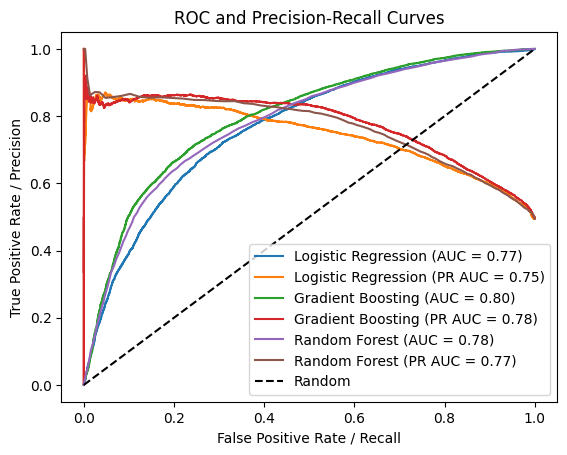

In [13]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc

results = []

# Perform cross-validation and evaluate each model
for model_name, model in models:
    if model_name == 'Gradient Boosting' or model_name == 'Random Forest':
        model.fit(X_train_scaled, y_train, sample_weight=[class_weights[int(label)] for label in y_train])
    else:
        model.fit(X_train_scaled, y_train)
    
    y_scores = cross_val_predict(model, X_test_scaled, y_test, cv=16, method='predict_proba')[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = roc_auc_score(y_test, y_scores)
    plt.plot(fpr, tpr, label='{} (AUC = {:.2f})'.format(model_name, roc_auc))

    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    plt.plot(recall, precision, label='{} (PR AUC = {:.2f})'.format(model_name, auc(recall, precision)))

    y_pred = cross_val_predict(model, X_test_scaled, y_test, cv=16)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append([model_name, precision, recall, f1, roc_auc])

# Create a DataFrame from the results
df_results = pd.DataFrame(results, columns=['Model', 'Precision', 'Recall', 'F1-Score', 'ROC AUC'])

# Plot the ROC and Precision-Recall curves
plt.plot([0, 1], [0, 1], 'k--', label='Random')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate / Recall')
plt.ylabel('True Positive Rate / Precision')
plt.title('ROC and Precision-Recall Curves')
plt.legend(loc='lower right')
plt.show()


В нашем примере, у обеих моделей одинаковое значение TP (True Positives), но разное количество объектов, помеченных как класс "1". В этом случае, метрика precision_recall_curve поможет наглядно оценить точность и полноту каждой модели на разных порогах классификации.

Метрика roc_auc_curve, с другой стороны, оценивает способность модели различать между классами в целом, независимо от уровня дисбаланса классов. Она основывается на значениях ложноположительных (FPR) и истинно положительных (TPR) ставок.

В контексте сильного дисбаланса классов, метрика roc_auc_curve может быть менее информативной.